# Pregunta 1 

### En esta sección, experimentaremos con redes convolucionales, conocidas como CNNs ó ConvNets. Para ello y con el fin de comparar con los resultados obtenidos por redes FF, reutilizaremos el dataset CIFAR10 utilizado en la tarea anterior. Si no dispone ya del dataset en su máquina, por favor siga a las instrucciones de descarga entregadas en la tarea anterior. Nota: Para esta actividad es bastante aconsejable entrenar las redes usando una GPU, ya que de otro modo los tiempos de entrenamiento son largos.

#### a) Preparación de conjunto de entrenameinto, validación y pruebas para entrenar la red neuronal.

In [1]:
#import cPickle
import _pickle as cPickle
import numpy as np
import os
import imread
import random
import matplotlib.pyplot as plt
import keras
from keras.optimizers import SGD, rmsprop
from keras.callbacks import LearningRateScheduler
import math
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D

Using TensorFlow backend.


In [2]:
def load_CIFAR_one(filename):
    with open(filename, 'rb') as f:
        datadict = cPickle.load(f, encoding='latin1')
        X = datadict['data']
        Y = datadict['labels']
        #X = np.transpose(np.reshape(X,(-1,32,32,3), order='F'),
        #                axes=(0,2,1,3)) #order batch,x,y,color
        Y = np.array(Y)
        return X, Y

def load_CIFAR10(PATH):
    xs = []
    ys = []
    for b in range(1,6):
        f = os.path.join(PATH, 'data_batch_%d' % (b, ))
        X, Y = load_CIFAR_one(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs) #entrenamiento
    Ytr = np.concatenate(ys) #entrenamiento
    del X, Y
    Xt, Yt = load_CIFAR_one(os.path.join(PATH, 'test_batch')) #pruebas
    limit_sup= random.randint(5000,50000)
    limit_inf= limit_sup - random.randint(0,5000)
    Xu= Xtr[limit_inf:limit_sup,0:3072] #conjunto de Validación
    Yu = Ytr[limit_inf:limit_sup] #conjunto de Validación
    return Xtr, Ytr, Xt, Yt, Xu, Yu

#carga de matrices
Xtr, Ytr, Xt, Yt, Xv, Yv = load_CIFAR10('../data/')

In [3]:
print (Xtr.shape)

(50000, 3072)


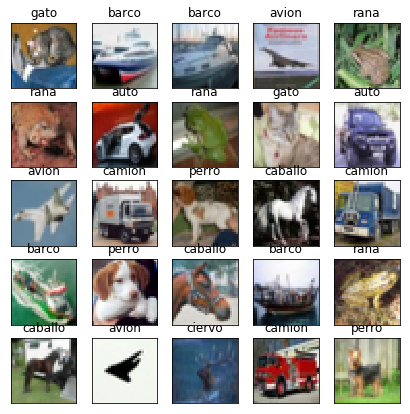

In [4]:
clases = ['avion','auto','pajaro','gato','ciervo',
          'perro','rana','caballo','barco','camion']
# dibujar imagenes
X= np.transpose(np.reshape(Xt,(-1,32,32,3), order='F'),
                        axes=(0,2,1,3)) #order batch,x,y,color
fig = plt.figure(figsize=(7,7))
for i in range(25):
    fig.add_subplot(5,5,(i+1),xticks=[], yticks=[])
    plt.title("{}".format(clases[Yt[i]]))
    plt.imshow(X[i])
plt.show()

In [5]:
Xtr=Xtr/255.0
Xt=Xt/255.0
Xv=Xv/255.0

#### A continuación se cambiará la dimensión matricial para entrenar la red.

In [6]:
num_classes=10

x_train = Xtr.reshape((Xtr.shape[0],32,32,3))
#x_train = x_train.transpose([0, 2, 3, 1]) #only if 'tf' dim-ordering is to be used
x_test= Xt.reshape((Xt.shape[0],32,32,3))
#x_test= x_test.transpose([0, 2, 3, 1])#remove if 'th' dim-ordering is to be used
x_val= Xv.reshape((Xv.shape[0],32,32,3))

y_train = keras.utils.to_categorical(Ytr, num_classes)
y_test = keras.utils.to_categorical(Yt, num_classes)
y_val = keras.utils.to_categorical(Yv, num_classes)


#### b) Definición de CNN con arquitectura C × P × C × P × F × F .

In [7]:
model = Sequential()
model.add(Convolution2D(64, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
activation_2 (Activation)    (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)              0         
__________

Se observa que la red tiene un total de 2.142.514 parametros. La red en cuestion reduce la dimensión luego re realizar la capa de pooling. Primero, la dimensión en de 32x32, luego 16x16 y antes de entra a FF es de 8x8.

#### c) Utilizando SGD se procederá a entrenar la red neuronal usando disminuidor de leanerng rate con el objetivo de que a medida de que avance el entrenamiento el learning rate disminuya para que encuentre un máximo rápido.

In [20]:
batch_size= 500

def step_decay(epoch):
    initial_lrate = 0.001
    lrate = initial_lrate * math.pow(0.5, math.floor((1+epoch)/5))
    lrate = max(lrate,0.00001)
    return lrate

opt = SGD(lr=0.0, momentum=0.9, decay=0.0)
lrate = LearningRateScheduler(step_decay)

model.compile(loss='mean_squared_error', optimizer=opt, metrics=['accuracy'])
hist_sgd= model.fit(x_train, y_train,batch_size=batch_size,epochs=25,
    validation_data=(x_val, y_val),shuffle=True,callbacks=[lrate], verbose= True)

Train on 50000 samples, validate on 1003 samples
Epoch 1/25
50000/50000 [==============================] - 76s - loss: 0.0903 - acc: 0.0953 - val_loss: 0.0902 - val_acc: 0.0907
Epoch 2/25
50000/50000 [==============================] - 38s - loss: 0.0902 - acc: 0.0804 - val_loss: 0.0901 - val_acc: 0.0768
Epoch 3/25
50000/50000 [==============================] - 38s - loss: 0.0901 - acc: 0.0791 - val_loss: 0.0900 - val_acc: 0.0847
Epoch 4/25
50000/50000 [==============================] - 38s - loss: 0.0900 - acc: 0.0846 - val_loss: 0.0900 - val_acc: 0.0907
Epoch 5/25
50000/50000 [==============================] - 38s - loss: 0.0900 - acc: 0.0883 - val_loss: 0.0899 - val_acc: 0.0917
Epoch 6/25
50000/50000 [==============================] - 39s - loss: 0.0899 - acc: 0.0899 - val_loss: 0.0899 - val_acc: 0.0917
Epoch 7/25
50000/50000 [==============================] - 38s - loss: 0.0899 - acc: 0.0909 - val_loss: 0.0899 - val_acc: 0.0947
Epoch 8/25
50000/50000 [==============================]

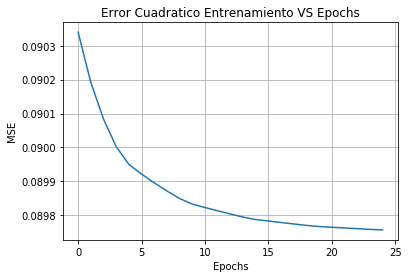

In [24]:
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.title("Error Cuadratico Entrenamiento VS Epochs")
plt.plot(hist_sgd.epoch, hist_sgd.history['loss'])
plt.grid(True)

plt.show()

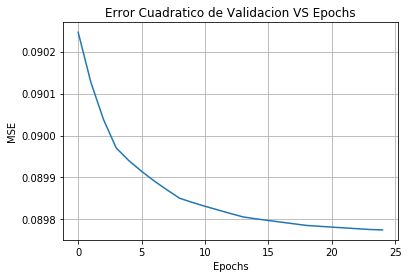

In [25]:
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.title("Error Cuadratico de Validacion VS Epochs")
plt.plot(hist_sgd.epoch, hist_sgd.history['val_loss'])
plt.grid(True)

plt.show()

A partir de los gráficos anteriores se observa que el error cuadrático de entrenamiento y el error de evaluación son practicamente iguales despues de un entrenamiento con 25 iteraciones.
También se aprecia que el error final de entrenamiento y evaluación es de 0,0898.

In [27]:
test = model.evaluate(x_test, y_test,verbose=1, batch_size=batch_size)
print ("\nLoss:",test[0], "Accuracy:",test[1])



10000/10000 [==============================] - 9s     

Loss: 0.0897604174912 Accuracy: 0.0960999999195


Al evaluar el modelo con los datos de test se llegó a que el error cuadrático tiene magnitud 0,0898362051696 y el accuracy es 0.133499998227, que es similar a los valores obtenidos en entrenamiento y validación.

#### d) Entranamiento de CNN con rmsProp, durante 25 epochs.

In [8]:
batch_size= 500
opt = rmsprop(lr=0.001, decay=1e-6)

model.compile(loss='mean_squared_error', optimizer=opt, metrics=['accuracy'])
hist_rmsprop = model.fit(x_train, y_train,batch_size=batch_size,epochs=25,
    validation_data=(x_val, y_val),shuffle=True, verbose= True)

Train on 50000 samples, validate on 678 samples
Epoch 1/25
50000/50000 [==============================] - 125s - loss: 0.0818 - acc: 0.2946 - val_loss: 0.0687 - val_acc: 0.4558
Epoch 2/25
50000/50000 [==============================] - 41s - loss: 0.0697 - acc: 0.4485 - val_loss: 0.0618 - val_acc: 0.5457
Epoch 3/25
50000/50000 [==============================] - 39s - loss: 0.0628 - acc: 0.5155 - val_loss: 0.0557 - val_acc: 0.5811
Epoch 4/25
50000/50000 [==============================] - 40s - loss: 0.0583 - acc: 0.5574 - val_loss: 0.0526 - val_acc: 0.6003
Epoch 5/25
50000/50000 [==============================] - 39s - loss: 0.0544 - acc: 0.5900 - val_loss: 0.0513 - val_acc: 0.6150
Epoch 6/25
50000/50000 [==============================] - 39s - loss: 0.0512 - acc: 0.6193 - val_loss: 0.0468 - val_acc: 0.6785
Epoch 7/25
50000/50000 [==============================] - 41s - loss: 0.0483 - acc: 0.6442 - val_loss: 0.0422 - val_acc: 0.7021
Epoch 8/25
50000/50000 [==============================]

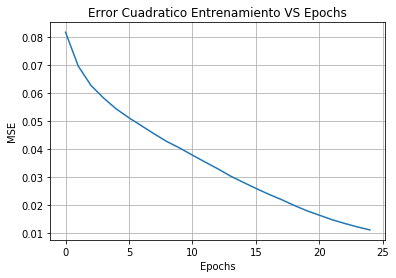

In [9]:
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.title("Error Cuadratico Entrenamiento VS Epochs")
plt.plot(hist_rmsprop.epoch, hist_rmsprop.history['loss'])
plt.grid(True)

plt.show()

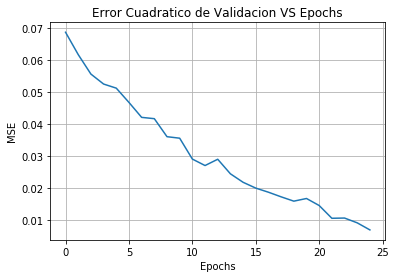

In [10]:
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.title("Error Cuadratico de Validacion VS Epochs")
plt.plot(hist_rmsprop.epoch, hist_rmsprop.history['val_loss'])
plt.grid(True)

plt.show()

Se observa en los gráficos anteriores que el error cuadrático asociado al entrenamiento y evaluación de la red reuronal son muy iguales en magnitud, siendo mayor el error de entrenamiento, con magnitud 0.0120 y el error de evaluación es menor, con magnitd 0.0093.

In [11]:
test = model.evaluate(x_test, y_test,verbose=1, batch_size=batch_size)
print ("\nLoss:",test[0], "Accuracy:",test[1])

10000/10000 [==============================] - 15s    

Loss: 0.0488555239514 Accuracy: 0.670599994063


Al evaluar el conjunto de datos de test en el modelo entrenado se observa que el error cuadrático aumenta significativamente en comparación al error de evaluación, por consiguiente, aumenta de 0.0093 a 0,0488.
Por otro lado, el accuracy de la evaluación en el conjunto de test es de 0,6655. Ya que en el conjunto de test el accuracy es de orden 0,9, se entiende que en el periodo de entrenamiento y evaluación se sobre estima el performance de la red neuronal.

#### e) Experimentación con una arquitectura del tipo C × C × P × C × C × P × F × F .
A continuación se define la red nueronal:

In [14]:
model = Sequential()
model.add(Convolution2D(64, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Convolution2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Convolution2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Convolution2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
activation_11 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
activation_12 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 16, 16, 128)       73856     
__________

Ahora se procederá a entrenar el modelo definido anteriormente mendiante rmsprop:

In [15]:
batch_size=500
opt = rmsprop(lr=0.001, decay=1e-6)

model.compile(loss='mean_squared_error', optimizer=opt, metrics=['accuracy'])
hist_rmsprop2 = model.fit(x_train, y_train,batch_size=batch_size,epochs=25,
    validation_data=(x_val, y_val),shuffle=True, verbose= True)


Train on 50000 samples, validate on 678 samples
Epoch 1/25
50000/50000 [==============================] - 131s - loss: 0.0843 - acc: 0.2514 - val_loss: 0.0760 - val_acc: 0.3614
Epoch 2/25
50000/50000 [==============================] - 124s - loss: 0.0727 - acc: 0.4117 - val_loss: 0.0624 - val_acc: 0.5088
Epoch 3/25
50000/50000 [==============================] - 124s - loss: 0.0648 - acc: 0.4942 - val_loss: 0.0589 - val_acc: 0.5324
Epoch 4/25
50000/50000 [==============================] - 124s - loss: 0.0589 - acc: 0.5473 - val_loss: 0.0530 - val_acc: 0.6106
Epoch 5/25
50000/50000 [==============================] - 124s - loss: 0.0535 - acc: 0.5949 - val_loss: 0.0450 - val_acc: 0.6740
Epoch 6/25
50000/50000 [==============================] - 124s - loss: 0.0492 - acc: 0.6334 - val_loss: 0.0394 - val_acc: 0.7212
Epoch 7/25
50000/50000 [==============================] - 124s - loss: 0.0454 - acc: 0.6645 - val_loss: 0.0405 - val_acc: 0.6917
Epoch 8/25
50000/50000 [=========================

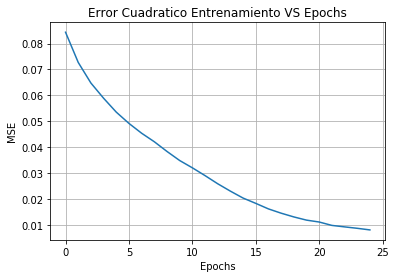

In [16]:
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.title("Error Cuadratico Entrenamiento VS Epochs")
plt.plot(hist_rmsprop2.epoch, hist_rmsprop2.history['loss'])
plt.grid(True)

plt.show()

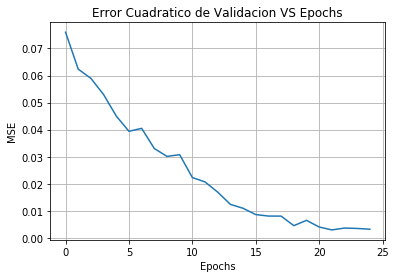

In [17]:
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.title("Error Cuadratico de Validacion VS Epochs")
plt.plot(hist_rmsprop2.epoch, hist_rmsprop2.history['val_loss'])
plt.grid(True)

plt.show()

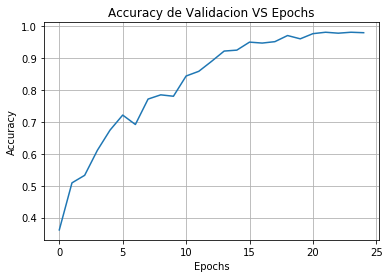

In [18]:
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy de Validacion VS Epochs")
plt.plot(hist_rmsprop2.epoch, hist_rmsprop2.history['val_acc'])
plt.grid(True)

plt.show()

In [19]:
test = model.evaluate(x_test, y_test,verbose=1, batch_size=batch_size)
print ("\nLoss:",test[0], "Accuracy:",test[1])

10000/10000 [==============================] - 9s     

Loss: 0.0499814752489 Accuracy: 0.691400000453


A partir de los gráficos realizados, se puede entender que en el periodo de entrenamiento y evaluación, ya en el 5to epoch el modelo alcanza precisión cercana al 0,7 en entrenamiento y 0,7632 en el conjunto de evaluación. En el gráfico "Accuracy de Validacion VS Epochs" se obserba una pendiente positiva que rápidamente llega a un accuracy más alto que 0,75.
Si se evalua el modelo en el conjunto de test, se observa que el accuracy es de 0,6654, que alto al saber que la red se entrenó con tan solo 6 apochs.

#### f) Cambio de capa de pooling por convolución, esperando el mismo efecto de reducción de dimensionalidad.

A continuación se definirá el modelo de la red.


In [20]:
model = Sequential()
model.add(Convolution2D(64, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Convolution2D(64, (3, 3), strides=(2, 2), padding='valid'))#cambio de pooling por convolucional
#model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Convolution2D(64, (3, 3), strides=(2, 2), padding='valid'))#cambio de pooling por convolucional
#model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
activation_17 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 15, 15, 64)        36928     
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 15, 15, 64)        36928     
_________________________________________________________________
activation_18 (Activation)   (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 7, 7, 64)          36928     
_________________________________________________________________
flatten_4 (Flatten)          (None, 3136)              0         
__________

Se observa que en efecto se reduce la dimensionalidad, sin embargo no funciona de igual manera que la capa de pooling, ya que la domensionalidad no se disminuye a la mitad.

Ahora se procederá a entrenar la red con rmsprop:


In [21]:
batch_size= 500
opt = rmsprop(lr=0.001, decay=1e-6)

model.compile(loss='mean_squared_error', optimizer=opt, metrics=['accuracy'])
hist_rmsprop3 = model.fit(x_train, y_train,batch_size=batch_size,epochs=25,
    validation_data=(x_val, y_val),shuffle=True, verbose= True)

Train on 50000 samples, validate on 678 samples
Epoch 1/25
50000/50000 [==============================] - 50s - loss: 0.0799 - acc: 0.3214 - val_loss: 0.0714 - val_acc: 0.4292
Epoch 2/25
50000/50000 [==============================] - 47s - loss: 0.0653 - acc: 0.4873 - val_loss: 0.0559 - val_acc: 0.5826
Epoch 3/25
50000/50000 [==============================] - 47s - loss: 0.0580 - acc: 0.5557 - val_loss: 0.0513 - val_acc: 0.6165
Epoch 4/25
50000/50000 [==============================] - 47s - loss: 0.0516 - acc: 0.6133 - val_loss: 0.0460 - val_acc: 0.6711
Epoch 5/25
50000/50000 [==============================] - 47s - loss: 0.0464 - acc: 0.6591 - val_loss: 0.0380 - val_acc: 0.7345
Epoch 6/25
50000/50000 [==============================] - 47s - loss: 0.0416 - acc: 0.7006 - val_loss: 0.0353 - val_acc: 0.7522
Epoch 7/25
50000/50000 [==============================] - 47s - loss: 0.0366 - acc: 0.7411 - val_loss: 0.0304 - val_acc: 0.7965
Epoch 8/25
50000/50000 [==============================] 

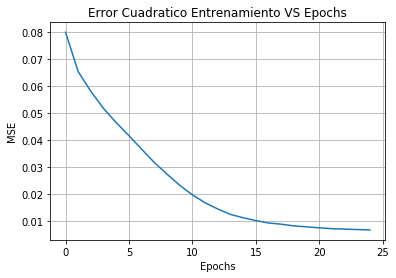

In [22]:
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.title("Error Cuadratico Entrenamiento VS Epochs")
plt.plot(hist_rmsprop3.epoch, hist_rmsprop3.history['loss'])
plt.grid(True)

plt.show()

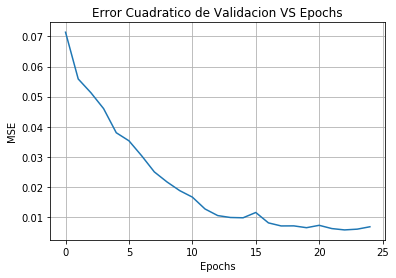

In [24]:
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.title("Error Cuadratico de Validacion VS Epochs")
plt.plot(hist_rmsprop3.epoch, hist_rmsprop3.history['val_loss'])
plt.grid(True)

plt.show()

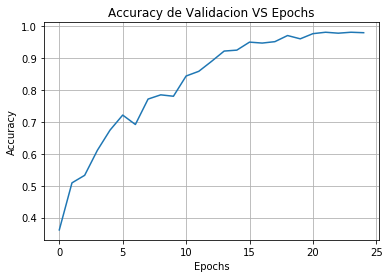

In [25]:
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy de Validacion VS Epochs")
plt.plot(hist_rmsprop2.epoch, hist_rmsprop2.history['val_acc'])
plt.grid(True)

plt.show()

In [26]:
test = model.evaluate(x_test, y_test,verbose=1, batch_size=batch_size)
print ("\nLoss:",test[0], "Accuracy:",test[1])

10000/10000 [==============================] - 3s     

Loss: 0.0627585105598 Accuracy: 0.617000007629


#### g) Una forma interesante de regularizar modelos entrenados para visión artificial consiste en “aumentar” el número de ejemplos de entrenamiento usando transformaciones sencillas como: rotaciones, corrimientos y reflexiones, tanto horizontales como verticales. Explique porqué este procedimiento podrı́a ayudar a mejorar el modelo. Evalúe experimentalmente la conveniencia de incorporarlo.

In [51]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    featurewise_center=False, # set input mean to 0 over the dataset
    samplewise_center=False, # set each sample mean to 0
    featurewise_std_normalization=False, # divide inputs by std of the dataset
    samplewise_std_normalization=False, # divide each input by its std
    zca_whitening=False, # apply ZCA whitening
    rotation_range=0, # randomly rotate images (degrees, 0 to 180)
    width_shift_range=0.1, # randomly shift images horizontally (fraction of width)
    height_shift_range=0.1, # randomly shift images vertically (fraction of height)
    horizontal_flip=True, # randomly flip images
    vertical_flip=False) # randomly flip images
datagen.fit(x_train)

ImportError: cannot import name 'NUMPY_MKL'

In [45]:
hist_datagen = model.fit_generator(datagen.flow(x_train, y_train,batch_size=batch_size),
    steps_per_epoch=x_train.shape[0]// batch_size,
    epochs=25,validation_data=(x_val, y_val))

NameError: name 'datagen' is not defined

In [ ]:
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.title("Error Cuadratico Entrenamiento VS Epochs")
plt.plot(hist_datagen.epoch, hist_datagen.history['loss'])
plt.grid(True)

plt.show()

In [ ]:
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.title("Error Cuadratico de Validacion VS Epochs")
plt.plot(hist_datagen.epoch, hist_datagen.history['val_loss'])
plt.grid(True)

plt.show()

In [ ]:
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy de Validacion VS Epochs")
plt.plot(hist_datagen.epoch, hist_datagen.history['val_acc'])
plt.grid(True)

plt.show()

In [ ]:
test = model.evaluate(x_test, y_test,verbose=1, batch_size=batch_size)
print "\nLoss:",test[0], "Accuracy:",test[1]

#### h) Elija una de las redes entrenadas en esta sección y determine los pares de objetos (por ejemplo “perros” con “gatos”) que la red tiende a confundir. Conjeture el motivo de tal confusión.